In [55]:
import uproot	
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import awkward as ak
from scipy.optimize import curve_fit
%matplotlib inline

In [56]:
# file = uproot.open("tracking_losses_ntuple_Bd2KstEE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")
file = uproot.open(
    "tracking_losses_ntuple_B_EndVeloP.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1"
)

# selektiere nur elektronen von B->K*ee
allcolumns = file.arrays()
found = allcolumns[
    (allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromB)
]  # B: 9056
lost = allcolumns[
    (allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromB)
]  # B: 1466

electrons = allcolumns[(allcolumns.isElectron) & (allcolumns.fromB)]

print(ak.num(found, axis=0), ak.num(lost, axis=0))
print(ak.num(electrons, axis=0))
# ak.count(found, axis=None)

41978 8523
50501


In [57]:
electrons[0]

<Record {all_endvtx_types_length: 7, ...} type='{all_endvtx_types_length: i...'>

In [58]:
lost_e = electrons["lost"]
e = electrons["energy"]
brem_pe = electrons["brem_photons_pe"]
brem_z = electrons["brem_vtx_z"]
brem_x = electrons["brem_vtx_x"]
length = electrons["brem_vtx_z_length"]
rad_length = electrons["rad_length_frac"]

brem = ak.ArrayBuilder()

for itr in range(ak.num(electrons, axis=0)):
    brem.begin_record()
    brem.field("lost").boolean(lost_e[itr])
    brem.field("rad_length_frac").append(rad_length[itr])
    # [:,"energy"] energy
    brem.field("energy").append(e[itr])
    # [:,"photon_length"] number of vertices
    brem.field("photon_length").integer(length[itr])
    # [:,"brem_photons_pe",:] photon energy
    brem.field("brem_photons_pe").append(brem_pe[itr])
    # [:,"brem_vtx_z",:] brem vtx z
    brem.field("brem_vtx_x").append(brem_x[itr])
    brem.field("brem_vtx_z").append(brem_z[itr])
    brem.end_record()

brem = ak.Array(brem)
brem[0]

<Record {lost: True, rad_length_frac: ..., ...} type='{lost: bool, rad_leng...'>

In [124]:
photon_cut = 0
photon_cut_ratio = 0.2

cut_brem = ak.ArrayBuilder()

for itr in range(ak.num(brem, axis=0)):
    cut_brem.begin_record()
    cut_brem.field("event_id").integer(itr)
    cut_brem.field("lost").boolean(brem[itr, "lost"])
    cut_brem.field("rad_length_frac").real(brem[itr, "rad_length_frac"])
    cut_brem.field("energy").real(brem[itr, "energy"])

    ph_length = brem[itr, "photon_length"]

    tmp_energy = brem[itr, "energy"]

    cut_brem.field("brem_photons_pe")
    cut_brem.begin_list()
    for jentry in range(brem[itr, "photon_length"]):
        if (
            brem[itr, "brem_vtx_z", jentry] > 2700
            or brem[itr, "brem_photons_pe", jentry] < photon_cut
            or brem[itr, "brem_photons_pe", jentry] < photon_cut_ratio * tmp_energy
        ):
            ph_length -= 1
            continue
        else:
            cut_brem.real(brem[itr, "brem_photons_pe", jentry])
            tmp_energy -= brem[itr, "brem_photons_pe", jentry]
    cut_brem.end_list()

    tmp_energy = brem[itr, "energy"]

    cut_brem.field("brem_vtx_x")
    cut_brem.begin_list()
    for jentry in range(brem[itr, "photon_length"]):
        if (
            brem[itr, "brem_vtx_z", jentry] > 2700
            or brem[itr, "brem_photons_pe", jentry] < photon_cut
            or brem[itr, "brem_photons_pe", jentry] < photon_cut_ratio * tmp_energy
        ):
            continue
        else:
            cut_brem.real(brem[itr, "brem_vtx_x", jentry])
            tmp_energy -= brem[itr, "brem_photons_pe", jentry]
    cut_brem.end_list()

    tmp_energy = brem[itr, "energy"]

    cut_brem.field("brem_vtx_z")
    cut_brem.begin_list()
    for jentry in range(brem[itr, "photon_length"]):
        if (
            brem[itr, "brem_vtx_z", jentry] > 2700
            or brem[itr, "brem_photons_pe", jentry] < photon_cut
            or brem[itr, "brem_photons_pe", jentry] < photon_cut_ratio * tmp_energy
        ):
            continue
        else:
            cut_brem.real(brem[itr, "brem_vtx_z", jentry])
            tmp_energy -= brem[itr, "brem_photons_pe", jentry]
    cut_brem.end_list()

    cut_brem.field("photon_length").integer(ph_length)

    cut_brem.end_record()

ntuple = ak.Array(cut_brem)

In [125]:
print(ak.sum(ak.num(ntuple["brem_photons_pe"], axis=1)))
print(ak.num(ntuple, axis=0))
ntuple[0]

24758
50501


<Record {event_id: 0, lost: True, ...} type='{event_id: int64, lost: bool, ...'>

In [126]:
# nulltuple = ntuple[:7000]
# onetuple = ntuple[7000:14000]
# twotuple = ntuple[14000:21000]
# threetuple = ntuple[21000:28000]
# fourtuple = ntuple[28000:35000]
# fivetuple = ntuple[35000:42000]
# sixtuple = ntuple[42000:49000]
# seventuple = ntuple[49000:]

# ntuple.nbytes

In [127]:
# cut = "tenCut"
# tree = "Tree10"
# with uproot.update("trackinglosses_B_photon_cuts.root") as outFile:
#     #outFile["README"] = "The Cuts are placed on the photons. noCut: 0*E, first: 0.05*E, second: 0.1*E, etc."
#     outFile.mktree(tree, {cut + "_event_id": ntuple["event_id"].type, cut + "_lost": ntuple["lost"].type, cut + "_rad_length_frac": ntuple["rad_length_frac"].type, cut + "_energy": ntuple["energy"].type, cut + "_brem_photons_pe": ntuple["brem_photons_pe"].type, cut + "_brem_vtx_x": ntuple["brem_vtx_x"].type, cut + "_brem_vtx_z": ntuple["brem_vtx_z"].type, cut + "_photon_length": ntuple["photon_length"].type} )
#     outFile[tree].extend( {cut + "_event_id": nulltuple["event_id"], cut + "_lost": nulltuple["lost"], cut + "_rad_length_frac": nulltuple["rad_length_frac"], cut + "_energy": nulltuple["energy"], cut + "_brem_photons_pe": nulltuple["brem_photons_pe"], cut + "_brem_vtx_x": nulltuple["brem_vtx_x"], cut + "_brem_vtx_z": nulltuple["brem_vtx_z"], cut + "_photon_length": nulltuple["photon_length"]} )
#     outFile[tree].extend( {cut + "_event_id": onetuple["event_id"], cut + "_lost": onetuple["lost"], cut + "_rad_length_frac": onetuple["rad_length_frac"], cut + "_energy": onetuple["energy"], cut + "_brem_photons_pe": onetuple["brem_photons_pe"], cut + "_brem_vtx_x": onetuple["brem_vtx_x"], cut + "_brem_vtx_z": onetuple["brem_vtx_z"], cut + "_photon_length": onetuple["photon_length"]} )
#     outFile[tree].extend( {cut + "_event_id": twotuple["event_id"], cut + "_lost": twotuple["lost"], cut + "_rad_length_frac": twotuple["rad_length_frac"], cut + "_energy": twotuple["energy"], cut + "_brem_photons_pe": twotuple["brem_photons_pe"], cut + "_brem_vtx_x": twotuple["brem_vtx_x"], cut + "_brem_vtx_z": twotuple["brem_vtx_z"], cut + "_photon_length": twotuple["photon_length"]} )
#     outFile[tree].extend( {cut + "_event_id": threetuple["event_id"], cut + "_lost": threetuple["lost"], cut + "_rad_length_frac": threetuple["rad_length_frac"], cut + "_energy": threetuple["energy"], cut + "_brem_photons_pe": threetuple["brem_photons_pe"], cut + "_brem_vtx_x": threetuple["brem_vtx_x"], cut + "_brem_vtx_z": threetuple["brem_vtx_z"], cut + "_photon_length": threetuple["photon_length"]} )
#     outFile[tree].extend( {cut + "_event_id": fourtuple["event_id"], cut + "_lost": fourtuple["lost"], cut + "_rad_length_frac": fourtuple["rad_length_frac"], cut + "_energy": fourtuple["energy"], cut + "_brem_photons_pe": fourtuple["brem_photons_pe"], cut + "_brem_vtx_x": fourtuple["brem_vtx_x"], cut + "_brem_vtx_z": fourtuple["brem_vtx_z"], cut + "_photon_length": fourtuple["photon_length"]} )
#     outFile[tree].extend( {cut + "_event_id": fivetuple["event_id"], cut + "_lost": fivetuple["lost"], cut + "_rad_length_frac": fivetuple["rad_length_frac"], cut + "_energy": fivetuple["energy"], cut + "_brem_photons_pe": fivetuple["brem_photons_pe"], cut + "_brem_vtx_x": fivetuple["brem_vtx_x"], cut + "_brem_vtx_z": fivetuple["brem_vtx_z"], cut + "_photon_length": fivetuple["photon_length"]} )
#     outFile[tree].extend( {cut + "_event_id": sixtuple["event_id"], cut + "_lost": sixtuple["lost"], cut + "_rad_length_frac": sixtuple["rad_length_frac"], cut + "_energy": sixtuple["energy"], cut + "_brem_photons_pe": sixtuple["brem_photons_pe"], cut + "_brem_vtx_x": sixtuple["brem_vtx_x"], cut + "_brem_vtx_z": sixtuple["brem_vtx_z"], cut + "_photon_length": sixtuple["photon_length"]} )
#     outFile[tree].extend( {cut + "_event_id": seventuple["event_id"], cut + "_lost": seventuple["lost"], cut + "_rad_length_frac": seventuple["rad_length_frac"], cut + "_energy": seventuple["energy"], cut + "_brem_photons_pe": seventuple["brem_photons_pe"], cut + "_brem_vtx_x": seventuple["brem_vtx_x"], cut + "_brem_vtx_z": seventuple["brem_vtx_z"], cut + "_photon_length": seventuple["photon_length"]} )

In [128]:
# data in cut_brem_found and cut_brem_lost

length_found = ak.num(ntuple[~ntuple.lost]["brem_photons_pe"], axis=0)
length_lost = ak.num(ntuple[ntuple.lost]["brem_photons_pe"], axis=0)
print(length_found + length_lost)
ntuple[1]

50501


<Record {event_id: 1, lost: False, ...} type='{event_id: int64, lost: bool,...'>

In [129]:
Z_found = ak.to_numpy(
    ak.sum(ntuple[~ntuple.lost]["brem_photons_pe"], axis=-1,
           keepdims=False)) / ak.to_numpy(ntuple[~ntuple.lost]["energy"])
Z_lost = ak.to_numpy(
    ak.sum(ntuple[ntuple.lost]["brem_photons_pe"], axis=-1,
           keepdims=False)) / ak.to_numpy(ntuple[ntuple.lost]["energy"])

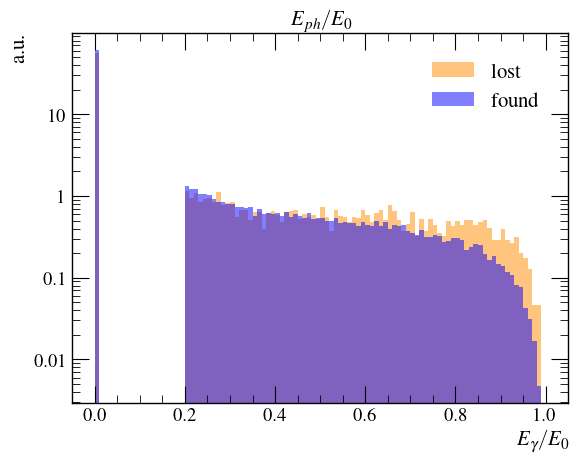

In [130]:
xlim = 0

plt.hist(
    Z_lost,
    bins=100,
    density=True,
    alpha=0.5,
    histtype="bar",
    color="darkorange",
    label="lost",
    range=[xlim, 1],
)
plt.hist(
    Z_found,
    bins=100,
    density=True,
    alpha=0.5,
    histtype="bar",
    color="blue",
    label="found",
    range=[xlim, 1],
)
plt.yscale("log")
plt.xlabel(r"$E_\gamma/E_0$")
plt.ylabel("a.u.")
plt.title(r"$E_{ph}/E_0$")
plt.legend()
plt.show()

In [131]:
tuple_found = ntuple[~ntuple.lost]
tuple_lost = ntuple[ntuple.lost]

brem_x_found = ak.to_numpy(ak.flatten(tuple_found["brem_vtx_x"]))
brem_z_found = ak.to_numpy(ak.flatten(tuple_found["brem_vtx_z"]))

brem_x_lost = ak.to_numpy(ak.flatten(tuple_lost["brem_vtx_x"]))
brem_z_lost = ak.to_numpy(ak.flatten(tuple_lost["brem_vtx_z"]))

n_found = len(brem_x_found)
n_lost = len(brem_x_lost)
print("found: ", n_found, ", lost: ", n_lost)
stretch_factor = n_lost / n_found
print(stretch_factor)
ak.flatten(tuple_found["brem_vtx_x"])

found:  19848 , lost:  4910
0.2473800886739218


<Array [-3.61, -33.8, -133, ..., 8.82, 12.8, -17.8] type='19848 * float64'>

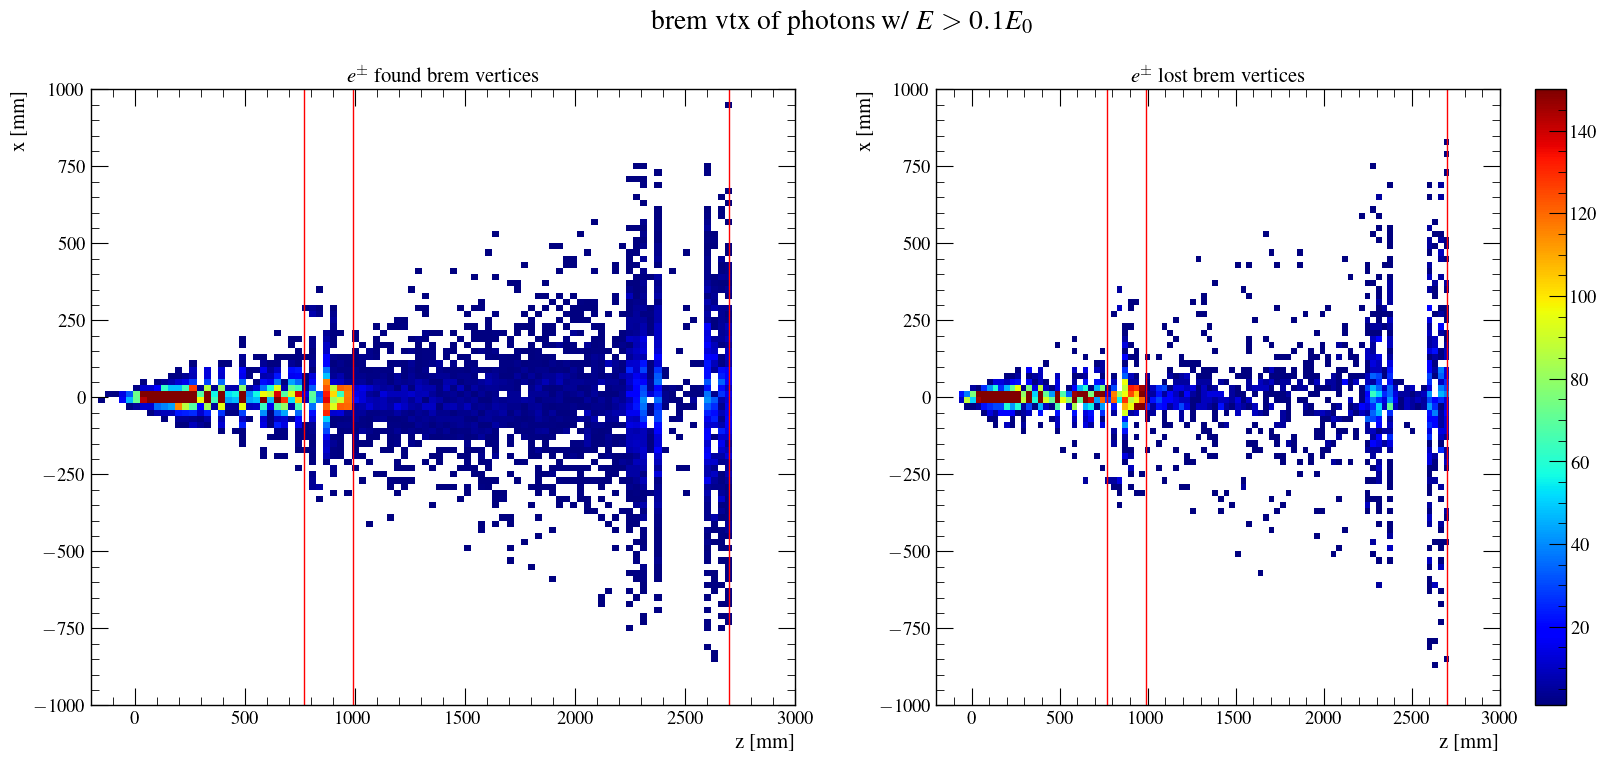

In [132]:
vmax = 150
nbins = 100

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

a0 = ax0.hist2d(
    brem_z_found,
    brem_x_found,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[-200, 3000], [-1000, 1000]],
)
ax0.vlines([770, 990, 2700], -1000, 1000, colors="red")
ax0.set_ylim(-1000, 1000)
ax0.set_xlim(-200, 3000)
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title(r"$e^\pm$ found brem vertices")

a1 = ax1.hist2d(
    brem_z_lost,
    brem_x_lost,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax * stretch_factor,
    range=[[-200, 3000], [-1000, 1000]],
)
ax1.vlines([770, 990, 2700], -1000, 1000, colors="red")
ax1.set_ylim(-1000, 1000)
ax1.set_xlim(-200, 3000)
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title(r"$e^\pm$ lost brem vertices")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.suptitle("brem vtx of photons w/ $E>0.1E_0$")
plt.colorbar(a0[3], ax=ax1)

plt.show()

In [133]:
energy_emissions = ak.ArrayBuilder()

for jelec in range(ak.num(ntuple, axis=0)):
    energy_emissions.begin_record()
    energy_emissions.field("lost").boolean(ntuple[jelec, "lost"])
    energy_emissions.field("energy").real(ntuple[jelec, "energy"])

    tmp_velo = 0
    tmp_richut = 0
    tmp_neither = 0
    tmp_velo_length = 0
    tmp_richut_length = 0
    tmp_neither_length = 0

    for jphoton in range(ak.num(ntuple[jelec]["brem_photons_pe"], axis=0)):
        if ntuple[jelec, "brem_vtx_z", jphoton] <= 770:
            tmp_velo += ntuple[jelec, "brem_photons_pe", jphoton]
            tmp_velo_length += 1
        elif (ntuple[jelec, "brem_vtx_z", jphoton] > 770) and (
            ntuple[jelec, "brem_vtx_z", jphoton] <= 2700
        ):
            tmp_richut += ntuple[jelec, "brem_photons_pe", jphoton]
            tmp_richut_length += 1
        else:
            tmp_neither += ntuple[jelec, "brem_photons_pe", jphoton]
            tmp_neither_length += 1

    energy_emissions.field("velo_length").integer(tmp_velo_length)
    energy_emissions.field("velo").real(tmp_velo)

    energy_emissions.field("rich_length").integer(tmp_richut_length)
    energy_emissions.field("rich").real(tmp_richut)

    energy_emissions.field("neither_length").integer(tmp_neither_length)
    energy_emissions.field("downstream").real(tmp_neither)

    energy_emissions.field("photon_length").integer(
        tmp_neither_length + tmp_richut_length + tmp_velo_length
    )

    # if (tmp_velo == 0) and (tmp_richut == 0):
    if (
        False  # (tmp_velo >= 0.5 * ntuple[jelec, "energy"])
        or ((tmp_velo == 0) and (tmp_richut == 0))
        or (ntuple[jelec, "energy"] - tmp_velo < 3000)
    ):
        energy_emissions.field("quality").integer(0)
    else:
        energy_emissions.field("quality").integer(1)

    energy_emissions.end_record()

energy_emissions = ak.Array(energy_emissions)

print(ak.num(energy_emissions, axis=0))

50501


In [134]:
energy_emissions[3]

<Record {lost: False, energy: 5.09e+04, ...} type='{lost: bool, energy: flo...'>

In [135]:
# efficiency berechnen als found in velo oder rich über alle elektronen
# dann kann man zusammenrechnen mit velo, rich, und allen anderen elektronen
# expected eff  = 81.19%

electrons_found = energy_emissions[~energy_emissions.lost]
electrons_lost = energy_emissions[energy_emissions.lost]

anz_found = ak.num(electrons[~electrons.lost], axis=0)
anz_lost = ak.num(electrons[electrons.lost], axis=0)
print("found: ", anz_found)
print("lost: ", anz_lost)

num_velo_found = 0
num_rich_found = 0
num_no_up_rad_found = 0
for itr in range(ak.num(electrons_found, axis=0)):
    if electrons_found[itr, "quality"] == 1:
        if electrons_found[itr, "velo"] >= electrons_found[itr, "rich"]:
            num_velo_found += 1
        else:
            num_rich_found += 1
    else:
        num_no_up_rad_found += 1

num_velo_lost = 0
num_rich_lost = 0
num_no_up_rad_lost = 0
for itr in range(ak.num(electrons_lost, axis=0)):
    if electrons_lost[itr, "quality"] == 1:
        if electrons_lost[itr, "velo"] >= electrons_lost[itr, "rich"]:
            num_velo_lost += 1
        else:
            num_rich_lost += 1
    else:
        num_no_up_rad_lost += 1

denom = ak.num(electrons, axis=0)
print(denom)

eff_velo = num_velo_found / denom

eff_rich = num_rich_found / denom

eff_other = ak.num(electrons_found[electrons_found.quality == 0],
                   axis=0) / denom

print("VELO energy emission, eff: ", eff_velo)

print("RICH1+UT energy emission, eff: ", eff_rich)

print("Neither, eff: ", eff_other)

print("total efficiency: ", eff_velo + eff_rich + eff_other)

print("efficiency: ", anz_found / (anz_found + anz_lost))

print("\nfound in velo/(found + lost in velo)")

eff_velo = num_velo_found / (num_velo_found + num_velo_lost)
eff_rich = num_rich_found / (num_rich_found + num_rich_lost)

eff_no_rad = num_no_up_rad_found / (num_no_up_rad_found + num_no_up_rad_lost)

print("VELO energy emission, eff: ", eff_velo)

print("RICH1+UT energy emission, eff: ", eff_rich)

print("eff von e die nicht strahlen: ", eff_no_rad)

found:  41978
lost:  8523
50501
VELO energy emission, eff:  0.18201619769905547
RICH1+UT energy emission, eff:  0.12653214787825984
Neither, eff:  0.5226827191540762
total efficiency:  0.8312310647313914
efficiency:  0.8312310647313914

found in velo/(found + lost in velo)
VELO energy emission, eff:  0.848831840428479
RICH1+UT energy emission, eff:  0.794479671764267
eff von e die nicht strahlen:  0.8345505706788074


In [136]:
print(ak.num(electrons[~electrons.lost], axis=0))
print(ak.num(electrons[electrons.lost], axis=0))
print(ak.num(electrons, axis=0))

41978
8523
50501


In [137]:
# energy_emissions = energy_emissions[energy_emissions.energy >= 5e3]

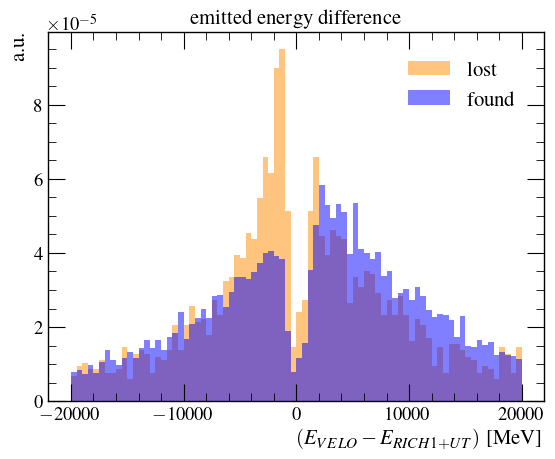

In [138]:
# energyspektren angucken von velo und rich

velo_found = ak.to_numpy(
    energy_emissions[(~energy_emissions.lost) & (energy_emissions.quality == 1)]["velo"]
)
rich_found = ak.to_numpy(
    energy_emissions[(~energy_emissions.lost) & (energy_emissions.quality == 1)]["rich"]
)
energy_found = ak.to_numpy(
    energy_emissions[(~energy_emissions.lost) & (energy_emissions.quality == 1)][
        "energy"
    ]
)

velo_lost = ak.to_numpy(
    energy_emissions[(energy_emissions.lost) & (energy_emissions.quality == 1)]["velo"]
)
rich_lost = ak.to_numpy(
    energy_emissions[(energy_emissions.lost) & (energy_emissions.quality == 1)]["rich"]
)
energy_lost = ak.to_numpy(
    energy_emissions[(energy_emissions.lost) & (energy_emissions.quality == 1)][
        "energy"
    ]
)

diff_found = velo_found - rich_found  # / energy_found
diff_lost = velo_lost - rich_lost  # / energy_lost

xlim = 20000
nbins = 80

plt.hist(
    diff_lost,
    bins=nbins,
    density=True,
    alpha=0.5,
    histtype="bar",
    color="darkorange",
    label="lost",
    range=[-xlim, xlim],
)
plt.hist(
    diff_found,
    bins=nbins,
    density=True,
    alpha=0.5,
    histtype="bar",
    color="blue",
    label="found",
    range=[-xlim, xlim],
)
# plt.xlim(-20000, 20000)
# plt.yscale("log")
plt.title("emitted energy difference")
plt.xlabel(r"$(E_{VELO} - E_{RICH1+UT})$ [MeV]")
plt.ylabel("a.u.")
plt.legend()
plt.show()

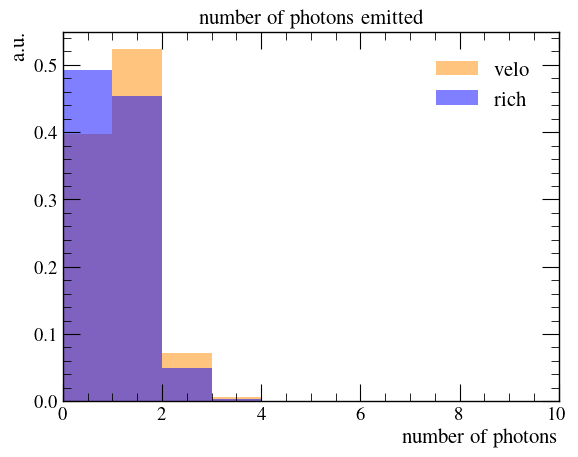

In [139]:
# number of brem vtx with E>x*E_0

number_velo = ak.to_numpy(
    energy_emissions[energy_emissions.quality == 1]["velo_length"])
number_rich = ak.to_numpy(
    energy_emissions[energy_emissions.quality == 1]["rich_length"])

plt.hist(
    number_velo,
    bins=10,
    density=True,
    alpha=0.5,
    histtype="bar",
    color="darkorange",
    label="velo",
    range=[0, 10],
)
plt.hist(
    number_rich,
    bins=10,
    density=True,
    alpha=0.5,
    histtype="bar",
    color="blue",
    label="rich",
    range=[0, 10],
)
plt.xlim(0, 10)
plt.title("number of photons emitted")
plt.xlabel("number of photons")
plt.ylabel("a.u.")
plt.legend()
plt.show()

In [140]:
""" 
photon cut = x*E_0
effs, all photons included: x=0
found in velo/(found + lost in velo)
VELO energy emission, eff:  0.8446167611094543
RICH1+UT energy emission, eff:  0.7961586121437423
eff von e die nicht strahlen:  0.7954674220963173
"""

' \nphoton cut = x*E_0\neffs, all photons included: x=0\nfound in velo/(found + lost in velo)\nVELO energy emission, eff:  0.8446167611094543\nRICH1+UT energy emission, eff:  0.7961586121437423\neff von e die nicht strahlen:  0.7954674220963173\n'